# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

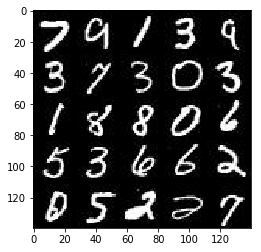

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

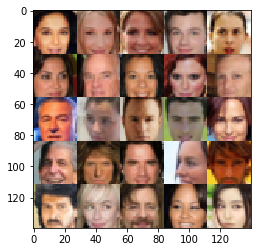

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,shape=[],name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def normalize_conv(input_layer,outputdim,kernel=4,stride=2,padding='same',is_training=True):
    conv = tf.layers.conv2d(input_layer,outputdim,kernel,stride,padding=padding,activation=None)
    conv = tf.layers.batch_normalization(conv,training=is_training)
    return conv

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # images 28*28*3
        
        conv1 = tf.layers.conv2d(images,128,4,2,padding='same',activation=None)
        conv1 = tf.maximum(conv1*0.4,conv1)
        # conv1 14*14*128
        conv2 = normalize_conv(conv1, 256)
        conv2 = tf.maximum(conv2*0.4,conv2)
        # conv2 7*7*256
        
        flat = tf.reshape(conv2,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        output = tf.nn.sigmoid(logits)
        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def normalize_deconv(input_layer,outputdim,kernel=4,stride=2,padding='same',is_training=True):
    conv = tf.layers.conv2d_transpose(input_layer,outputdim,kernel,stride,padding=padding,activation=None)
    conv = tf.layers.batch_normalization(conv,training=is_training)
    return conv

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # input of z dim_z
        project = tf.layers.dense(z, 7*7*256)
        reshape = tf.reshape(project, (-1,7,7,256))
        # reshape 7*7*256
        deconv1 = normalize_deconv(reshape,128)
        deconv1 = tf.maximum(deconv1*0.4,deconv1)
        # deconv 14*14*128
        
        logit = normalize_deconv(deconv1, out_channel_dim)
        output = tf.tanh(logit)*0.5
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 200 ==0:
                    show_generator_output(sess,16,input_z,data_shape[3],data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.0813... Generator Loss: 2.9618
Epoch 1/2... Discriminator Loss: 0.0405... Generator Loss: 3.5263
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 4.1594
Epoch 1/2... Discriminator Loss: 0.0084... Generator Loss: 5.1209
Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 4.7015
Epoch 1/2... Discriminator Loss: 0.0101... Generator Loss: 5.5099
Epoch 1/2... Discriminator Loss: 0.0066... Generator Loss: 6.5162
Epoch 1/2... Discriminator Loss: 0.0032... Generator Loss: 7.0769
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 6.8804
Epoch 1/2... Discriminator Loss: 0.0055... Generator Loss: 6.4766


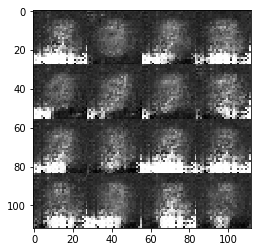

Epoch 1/2... Discriminator Loss: 0.0039... Generator Loss: 6.4227
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 6.2825
Epoch 1/2... Discriminator Loss: 0.0034... Generator Loss: 6.1903
Epoch 1/2... Discriminator Loss: 26.3944... Generator Loss: 24.2520
Epoch 1/2... Discriminator Loss: 0.1125... Generator Loss: 3.8930
Epoch 1/2... Discriminator Loss: 0.0239... Generator Loss: 4.6309
Epoch 1/2... Discriminator Loss: 0.0078... Generator Loss: 5.2160
Epoch 1/2... Discriminator Loss: 0.0078... Generator Loss: 5.5066
Epoch 1/2... Discriminator Loss: 0.0050... Generator Loss: 6.5092
Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.9502


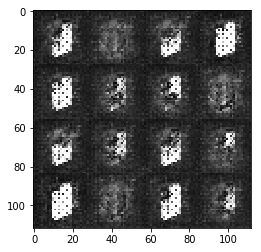

Epoch 1/2... Discriminator Loss: 0.0065... Generator Loss: 6.0690
Epoch 1/2... Discriminator Loss: 0.0034... Generator Loss: 6.1068
Epoch 1/2... Discriminator Loss: 0.0095... Generator Loss: 5.6630
Epoch 1/2... Discriminator Loss: 0.0068... Generator Loss: 5.2413
Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 5.9414
Epoch 1/2... Discriminator Loss: 0.0048... Generator Loss: 5.7227
Epoch 1/2... Discriminator Loss: 0.0181... Generator Loss: 4.3276
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.8839
Epoch 1/2... Discriminator Loss: 0.1324... Generator Loss: 3.6371
Epoch 1/2... Discriminator Loss: 0.1052... Generator Loss: 2.6248


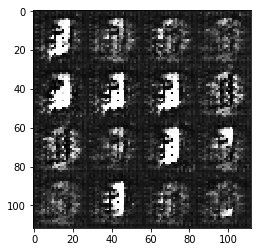

Epoch 1/2... Discriminator Loss: 0.0341... Generator Loss: 4.1535
Epoch 1/2... Discriminator Loss: 0.0291... Generator Loss: 4.0521
Epoch 1/2... Discriminator Loss: 0.0066... Generator Loss: 6.3551
Epoch 1/2... Discriminator Loss: 0.0160... Generator Loss: 4.9208
Epoch 1/2... Discriminator Loss: 0.0300... Generator Loss: 4.0240
Epoch 1/2... Discriminator Loss: 0.0223... Generator Loss: 4.7221
Epoch 1/2... Discriminator Loss: 0.0109... Generator Loss: 5.6416
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 2.5442
Epoch 1/2... Discriminator Loss: 0.0584... Generator Loss: 3.2415
Epoch 1/2... Discriminator Loss: 0.0333... Generator Loss: 4.1217


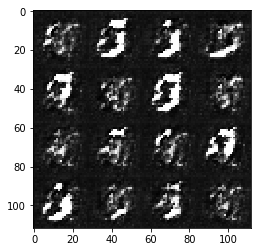

Epoch 1/2... Discriminator Loss: 0.0564... Generator Loss: 3.9439
Epoch 1/2... Discriminator Loss: 0.0151... Generator Loss: 5.5336
Epoch 1/2... Discriminator Loss: 0.0790... Generator Loss: 4.2573
Epoch 1/2... Discriminator Loss: 0.0317... Generator Loss: 4.0902
Epoch 1/2... Discriminator Loss: 0.0609... Generator Loss: 3.7616
Epoch 1/2... Discriminator Loss: 0.0683... Generator Loss: 3.3844
Epoch 1/2... Discriminator Loss: 0.0448... Generator Loss: 4.3531
Epoch 1/2... Discriminator Loss: 0.0469... Generator Loss: 3.7722
Epoch 1/2... Discriminator Loss: 0.0976... Generator Loss: 2.7553
Epoch 1/2... Discriminator Loss: 0.0379... Generator Loss: 3.9658


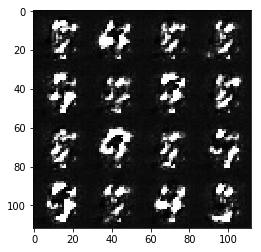

Epoch 1/2... Discriminator Loss: 0.0167... Generator Loss: 4.6870
Epoch 1/2... Discriminator Loss: 0.1755... Generator Loss: 4.7569
Epoch 1/2... Discriminator Loss: 0.1511... Generator Loss: 2.8549
Epoch 1/2... Discriminator Loss: 0.1002... Generator Loss: 4.3330
Epoch 1/2... Discriminator Loss: 0.0559... Generator Loss: 3.5190
Epoch 1/2... Discriminator Loss: 0.0856... Generator Loss: 3.9901
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 7.9110
Epoch 1/2... Discriminator Loss: 0.1930... Generator Loss: 2.4128
Epoch 1/2... Discriminator Loss: 0.1598... Generator Loss: 4.5555
Epoch 1/2... Discriminator Loss: 0.0562... Generator Loss: 3.7215


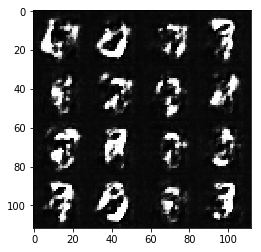

Epoch 1/2... Discriminator Loss: 0.2378... Generator Loss: 1.8225
Epoch 1/2... Discriminator Loss: 1.8712... Generator Loss: 8.6204
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 1.7429
Epoch 1/2... Discriminator Loss: 0.2443... Generator Loss: 4.0952
Epoch 1/2... Discriminator Loss: 0.1313... Generator Loss: 2.8095
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 1.7092
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 6.1038
Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 3.5477
Epoch 1/2... Discriminator Loss: 0.2102... Generator Loss: 3.0715
Epoch 1/2... Discriminator Loss: 0.2752... Generator Loss: 4.4055


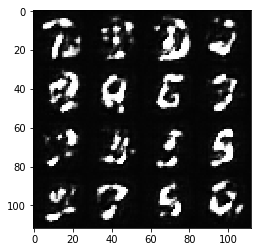

Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 3.1800
Epoch 1/2... Discriminator Loss: 0.1631... Generator Loss: 3.1731
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 0.2085... Generator Loss: 2.4087
Epoch 1/2... Discriminator Loss: 0.4021... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 4.2559
Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 2.6436
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 0.8367


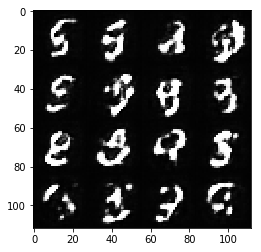

Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.7512
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 4.9399
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 2.1245
Epoch 1/2... Discriminator Loss: 0.2130... Generator Loss: 2.3281
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 2.0443
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 1.6390
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 0.4256... Generator Loss: 1.9829


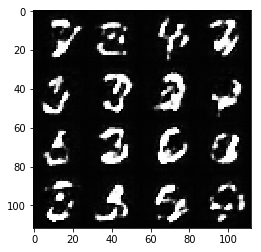

Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 4.7142
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 1.8680
Epoch 2/2... Discriminator Loss: 0.7181... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 3.6039
Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.1629
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 3.0022
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.0780


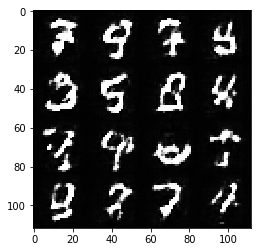

Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 2.2182
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 2.1835
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.4495
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.3785


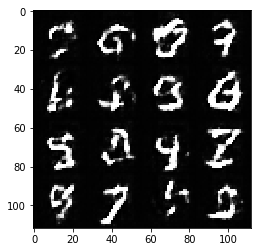

Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.3776
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 3.0248
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.4118
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 0.2898
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.3013


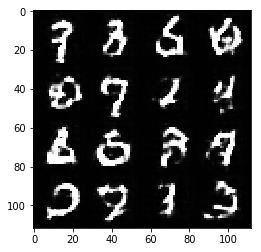

Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.8494
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.2515
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.5048
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 2.2355
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 2.3536
Epoch 2/2... Discriminator Loss: 1.6682... Generator Loss: 3.4478
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.2772
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 2.4608


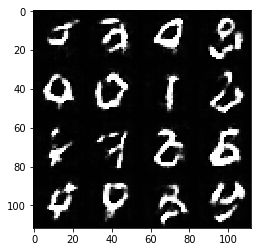

Epoch 2/2... Discriminator Loss: 1.7602... Generator Loss: 0.2298
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.3844
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 2.4377
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 2.9800
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 2.0388
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 2.3522
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 2.6342


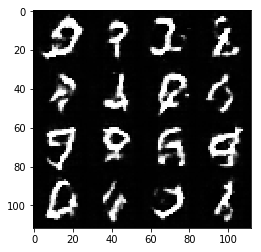

Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 1.7826
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.3474
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.3497
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.6017
Epoch 2/2... Discriminator Loss: 0.6626... Generator Loss: 1.7676
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 2.1201
Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 1.4928
Epoch 2/2... Discriminator Loss: 2.0072... Generator Loss: 0.1728
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 2.9734


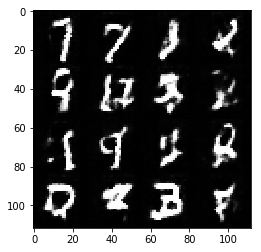

Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 2.0744
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 1.6016
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 2.1229
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.9232
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 0.6714


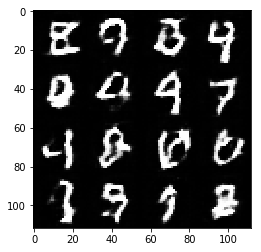

Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 1.4865
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 2.1079
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.2202
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 1.9600
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.3777
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 2.1726


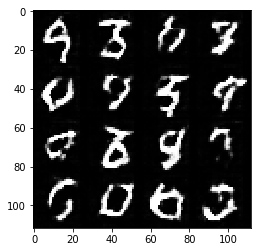

Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.5647
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.9336
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.4443
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.0163


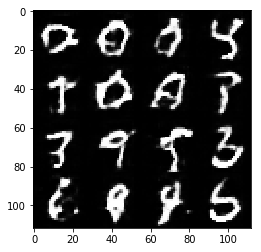

Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.4587
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 1.4128
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.4315


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 0.3178... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 2.7225
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.3872


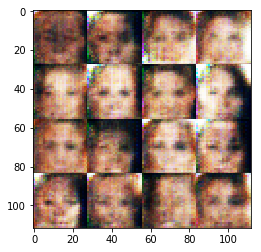

Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.3919


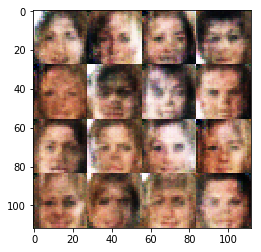

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6009


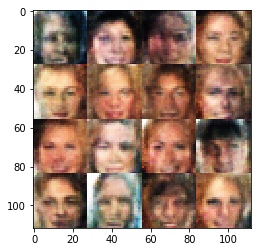

Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.3262


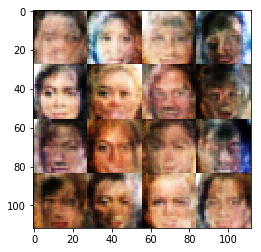

Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.7546... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7935


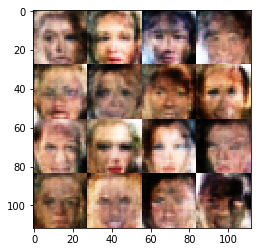

Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.5279


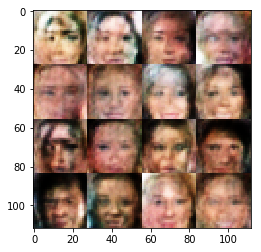

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.7994... Generator Loss: 0.3102
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7829


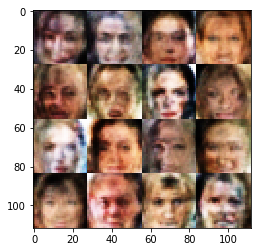

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4260


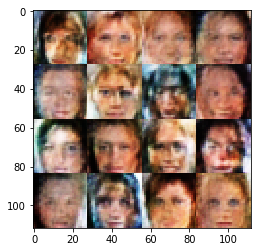

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6143


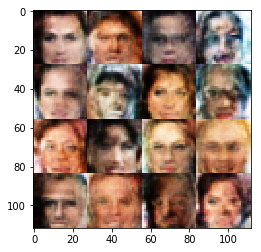

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 2.2020... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6188


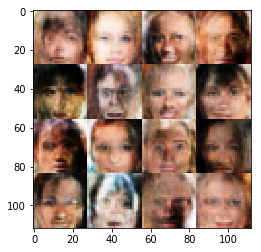

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6737


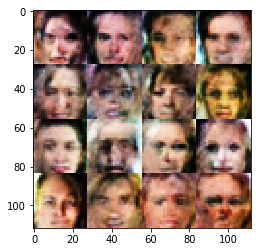

Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5429


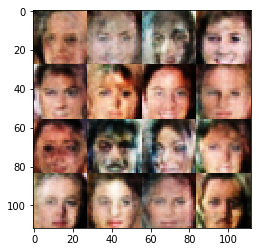

Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6339


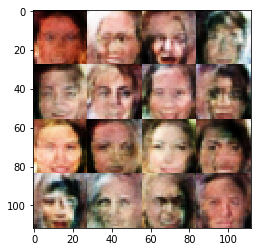

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9255


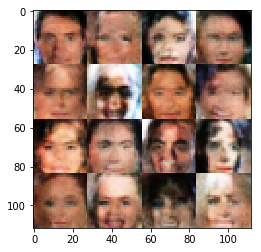

Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5106


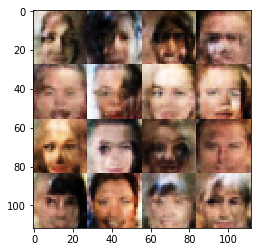

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8000


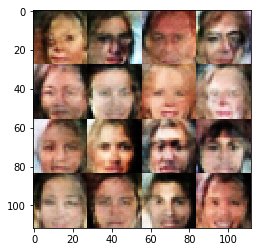

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 2.1574... Generator Loss: 1.7476


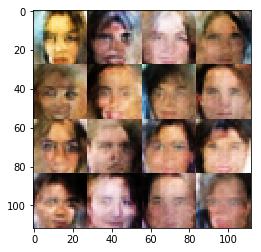

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6802


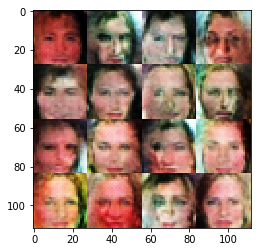

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6108


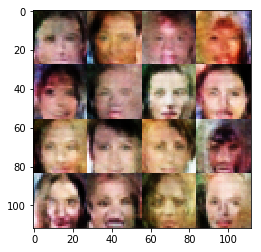

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5783


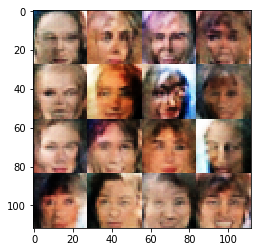

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7836


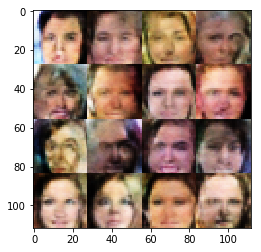

Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.8128... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7515


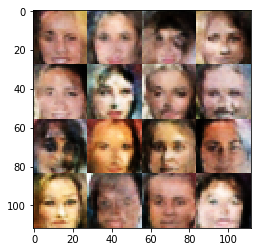

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8857


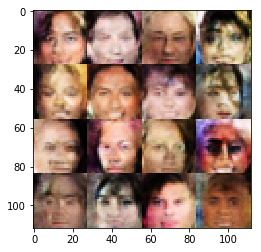

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.9077


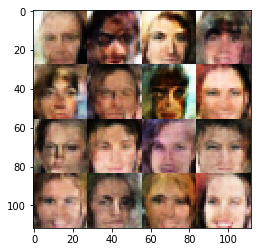

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7341


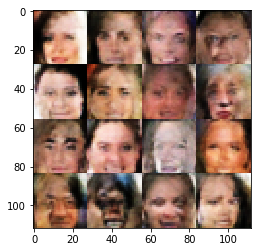

Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9682


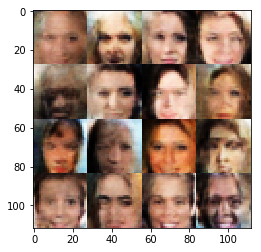

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6965


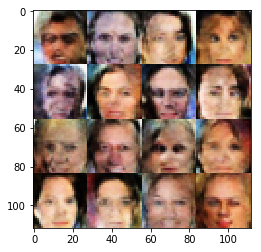

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.8051... Generator Loss: 0.2402
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7053


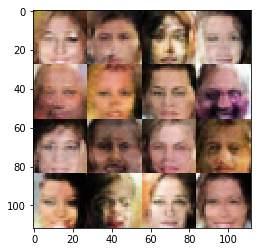

Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.4381


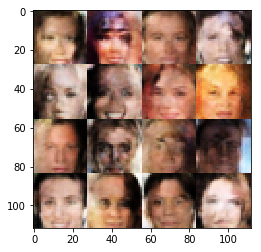

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 2.2407... Generator Loss: 1.9677
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.9825


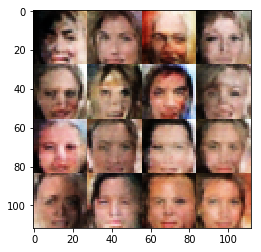

Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 2.5579... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.9434


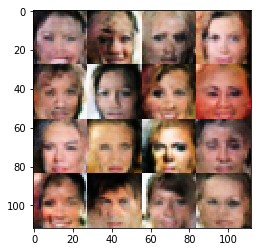

Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8439


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。